In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# set seed
seed = 42
random.seed(seed)
np.random.seed(seed)

In [3]:
# load cleaned data
# train_data = pd.read_csv('cleaned_train.csv')
train_data = pd.read_csv('./data/preprocessed_train_CorrDrop.csv')
train_data.set_index('UID', inplace=True)
train_labels = train_data['Target']
train_data.drop(columns=['Target'], inplace=True)

# test_data = pd.read_csv('cleaned_test.csv')
test_data = pd.read_csv('./data/preprocessed_test_CorrDrop.csv')
test_data.set_index('UID', inplace=True)


In [4]:
# map labels to integers
train_labels = train_labels.map({'low': 0, 'medium': 1, 'high': 2})

In [5]:
# do normalization


scaler = StandardScaler()
train_data = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns, index=train_data.index)
test_data = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns, index=test_data.index)

In [6]:
# make train data with 22514 data of each class

# Separate the data based on the target classes
low_class = train_data[train_labels == 0]
medium_class = train_data[train_labels == 1]
high_class = train_data[train_labels == 2]

# Get the number of samples in each class
low_class_count = len(low_class)
medium_class_count = len(medium_class)
high_class_count = len(high_class)

# Set the number of samples to be selected from each class
num_samples = min(low_class_count, medium_class_count, high_class_count)

# Randomly sample data from each class
low_class_sample = low_class.sample(n=num_samples, random_state=seed)
medium_class_sample = medium_class.sample(n=num_samples, random_state=seed)
high_class_sample = high_class.sample(n=num_samples, random_state=seed)

# Concatenate the sampled data
train_data_sampled = pd.concat([low_class_sample, medium_class_sample, high_class_sample])

# Separate the features and target variable
X_sampled = train_data_sampled
y_sampled = train_labels.loc[train_data_sampled.index]

# Display the count of unique values in the target variable
print(y_sampled.value_counts())

Target
0    22514
1    22514
2    22514
Name: count, dtype: int64


In [7]:
# do data split

# Split the data into training and validation sets
# X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_labels, test_size=0.05, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_sampled, y_sampled, test_size=0.05, random_state=seed)

# Display the shapes of the training and validation sets
print(f"X_train shape: {X_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_valid shape: {y_valid.shape}")


X_train shape: (64164, 11)
X_valid shape: (3378, 11)
y_train shape: (64164,)
y_valid shape: (3378,)


In [8]:
# neural network model in pytorch

# Set the device to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert the training and validation data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
X_valid_tensor = torch.tensor(X_valid.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.long).to(device)

In [9]:
# Create a DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

In [10]:
# Define the neural network model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        self.model = nn.Sequential(
            # nn.Linear(18, 64),
            # nn.ReLU(),
            # nn.Linear(64, 128),
            # nn.ReLU(),
            # nn.Linear(128, 64),
            # nn.ReLU(),
            # nn.Linear(64, 3)
            nn.Linear(11, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 3)
        )

    def forward(self, x):
        return self.model(x)

In [11]:
# Create an instance of the model
model = MLP().to(device)

# Define the loss function and the optimizer
# criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 1.0, 1.0]).to(device))
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

In [12]:
# Train the model
num_epochs = 200
loss_epoch = []
valid_loss_epoch = []
valid_f1_epoch = []
best_f1 = 0.0

for epoch in range(num_epochs):
    model.train()

    loss_temp = 0.0

    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        loss_temp += loss.item()

        # accuracy
        _, predicted = torch.max(outputs, 1)
        total = targets.size(0)
        correct = (predicted == targets).sum().item()
        accuracy = correct / total

        # f1 score
        f1 = f1_score(targets.cpu().numpy(), predicted.cpu().numpy(), average='macro')

        # if (i + 1) % 100 == 0:
            # print(f"Epoch {epoch + 1}/{num_epochs}, Step {i + 1}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

    loss_epoch.append(loss_temp)

    if (epoch + 1 ):
        model.eval()

        with torch.no_grad():
            correct = 0
            total = 0

            # f1 score
            y_true = []
            y_pred = []

            for inputs, targets in valid_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)

                total += targets.size(0)
                correct += (predicted == targets).sum().item()

                y_true.extend(targets.cpu().numpy().tolist())
                y_pred.extend(predicted.cpu().numpy().tolist())
            accuracy = correct / total
            f1 = f1_score(y_true, y_pred, average='macro')

            valid_loss_epoch.append(loss.item())
            valid_f1_epoch.append(f1)

            # save the model getting best f1 score,
            if f1 > best_f1:
                best_f1 = f1
                torch.save(model.state_dict(), 'best_model.pth')
                print (f"Best model saved at epoch {epoch + 1}, F1 Score: {f1:.4f}")

            print(f"Epoch {epoch + 1}/{num_epochs}, Validation Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
            


Best model saved at epoch 1, F1 Score: 0.3845
Epoch 1/200, Validation Accuracy: 0.3917, F1 Score: 0.3845
Best model saved at epoch 2, F1 Score: 0.4046
Epoch 2/200, Validation Accuracy: 0.4118, F1 Score: 0.4046
Best model saved at epoch 3, F1 Score: 0.4104
Epoch 3/200, Validation Accuracy: 0.4210, F1 Score: 0.4104
Epoch 4/200, Validation Accuracy: 0.4156, F1 Score: 0.4058
Best model saved at epoch 5, F1 Score: 0.4125
Epoch 5/200, Validation Accuracy: 0.4189, F1 Score: 0.4125
Best model saved at epoch 6, F1 Score: 0.4180
Epoch 6/200, Validation Accuracy: 0.4230, F1 Score: 0.4180
Best model saved at epoch 7, F1 Score: 0.4188
Epoch 7/200, Validation Accuracy: 0.4236, F1 Score: 0.4188
Best model saved at epoch 8, F1 Score: 0.4197
Epoch 8/200, Validation Accuracy: 0.4269, F1 Score: 0.4197
Epoch 9/200, Validation Accuracy: 0.4177, F1 Score: 0.4170
Epoch 10/200, Validation Accuracy: 0.4065, F1 Score: 0.4053
Epoch 11/200, Validation Accuracy: 0.4121, F1 Score: 0.4098
Epoch 12/200, Validation Ac

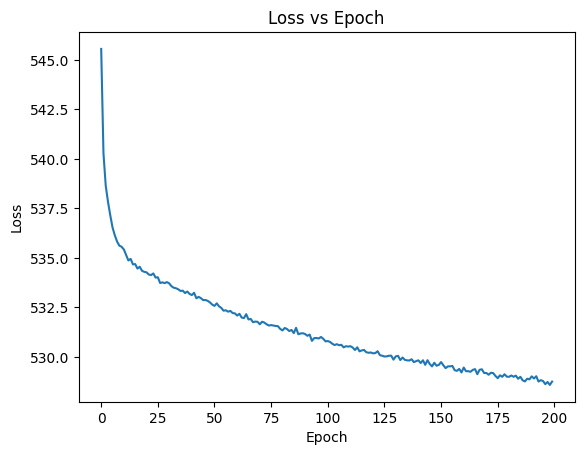

In [13]:
# plot loss

plt.plot(loss_epoch)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.show()

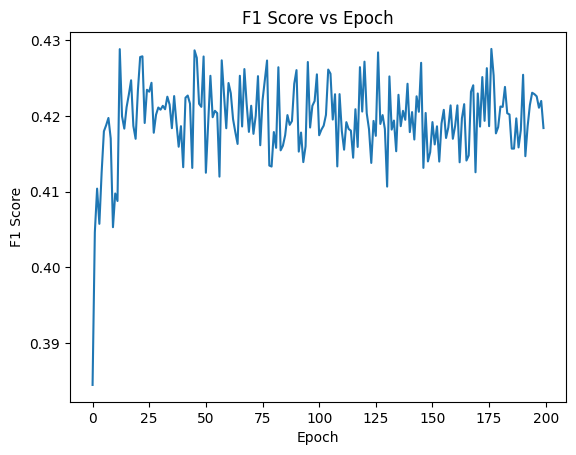

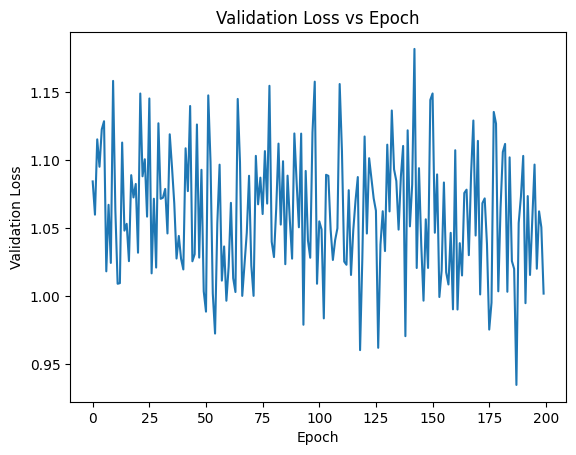

In [14]:
# plot f1 score, val loss
plt.plot(valid_f1_epoch)
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Epoch')
plt.show()

plt.plot(valid_loss_epoch)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Epoch')
plt.show()

In [16]:
# run the 'best_model.pth' on test data

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Convert the test data to a PyTorch tensor
X_test_tensor = torch.tensor(test_data.values, dtype=torch.float32).to(device)

# Create a DataLoader
test_dataset = TensorDataset(X_test_tensor)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Make predictions on the test data
model.eval()

predictions = []

with torch.no_grad():
    for inputs in test_loader:
        outputs = model(inputs[0])
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy().tolist())

# Save the predictions to a CSV file
submission = pd.DataFrame({'UID': test_data.index, 'Target': predictions})

# map target to original value
submission['Target'] = submission['Target'].map({0: 'low', 1: 'medium', 2: 'high'})

submission.to_csv('submission_8.csv', index=False)

/tmp/ipykernel_800490/2144503395.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


In [17]:
# unique values in the submission
print(submission['Target'].value_counts())

Target
medium    6844
high      4948
low       4129
Name: count, dtype: int64
